<a href="https://colab.research.google.com/github/WenchaoHanSRI/U_net/blob/main/Inspect_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and upcompress the image file package  
(the file in toatl is about 2GB, please make sure you have enough storage on you google drive. Also, this might take a few minutes for file downloading)

In [2]:
!pip install rarfile
import urllib.request
import zipfile
import rarfile
from PIL import Image
from matplotlib import pyplot as plt
from itertools import islice
import random
import os

url = "https://figshare.com/ndownloader/files/34969398"

user_agent = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 \
(KHTML, like Gecko) Chrome/105.0.0.0 Safari/124.56"

save_dir = "/content"

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', user_agent)]
urllib.request.install_opener(opener)
filehandle, _ = urllib.request.urlretrieve(url)
rar_file_object = rarfile.RarFile(filehandle, 'r')
rar_file_object.extractall(save_dir)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%cd /content/

/content


Get the image directory

# Randomly selection 50 samples from the training sample

In [4]:
## get the image directories
cur_dir = os.getcwd()
dir_list = os.listdir(cur_dir)
dir_img = [dir for dir in dir_list if 'Fundus' in dir][0]
fullpath = os.path.join('/content', dir_img)

## random pick 50 samples
train_dir = os.path.join(fullpath, 'train')
test_dir = os.path.join(fullpath, 'test')
train_ds_img = train_dir +'/Original'
test_ds_img = test_dir +'/Original'
train_img_list = sorted([f for f in os.listdir(train_ds_img) if f.endswith('.png')])
test_img_list = sorted([f for f in os.listdir(test_ds_img) if f.endswith('.png')])
random.seed(1)  ## random seed for reproduce the same images
sub_imglist = random.sample(train_img_list, 50)

# Display 50 random samples from training dataset
# Note that those images vary largely in brightness and the contrast, such that some thin vessls are barely visiable in some cases.

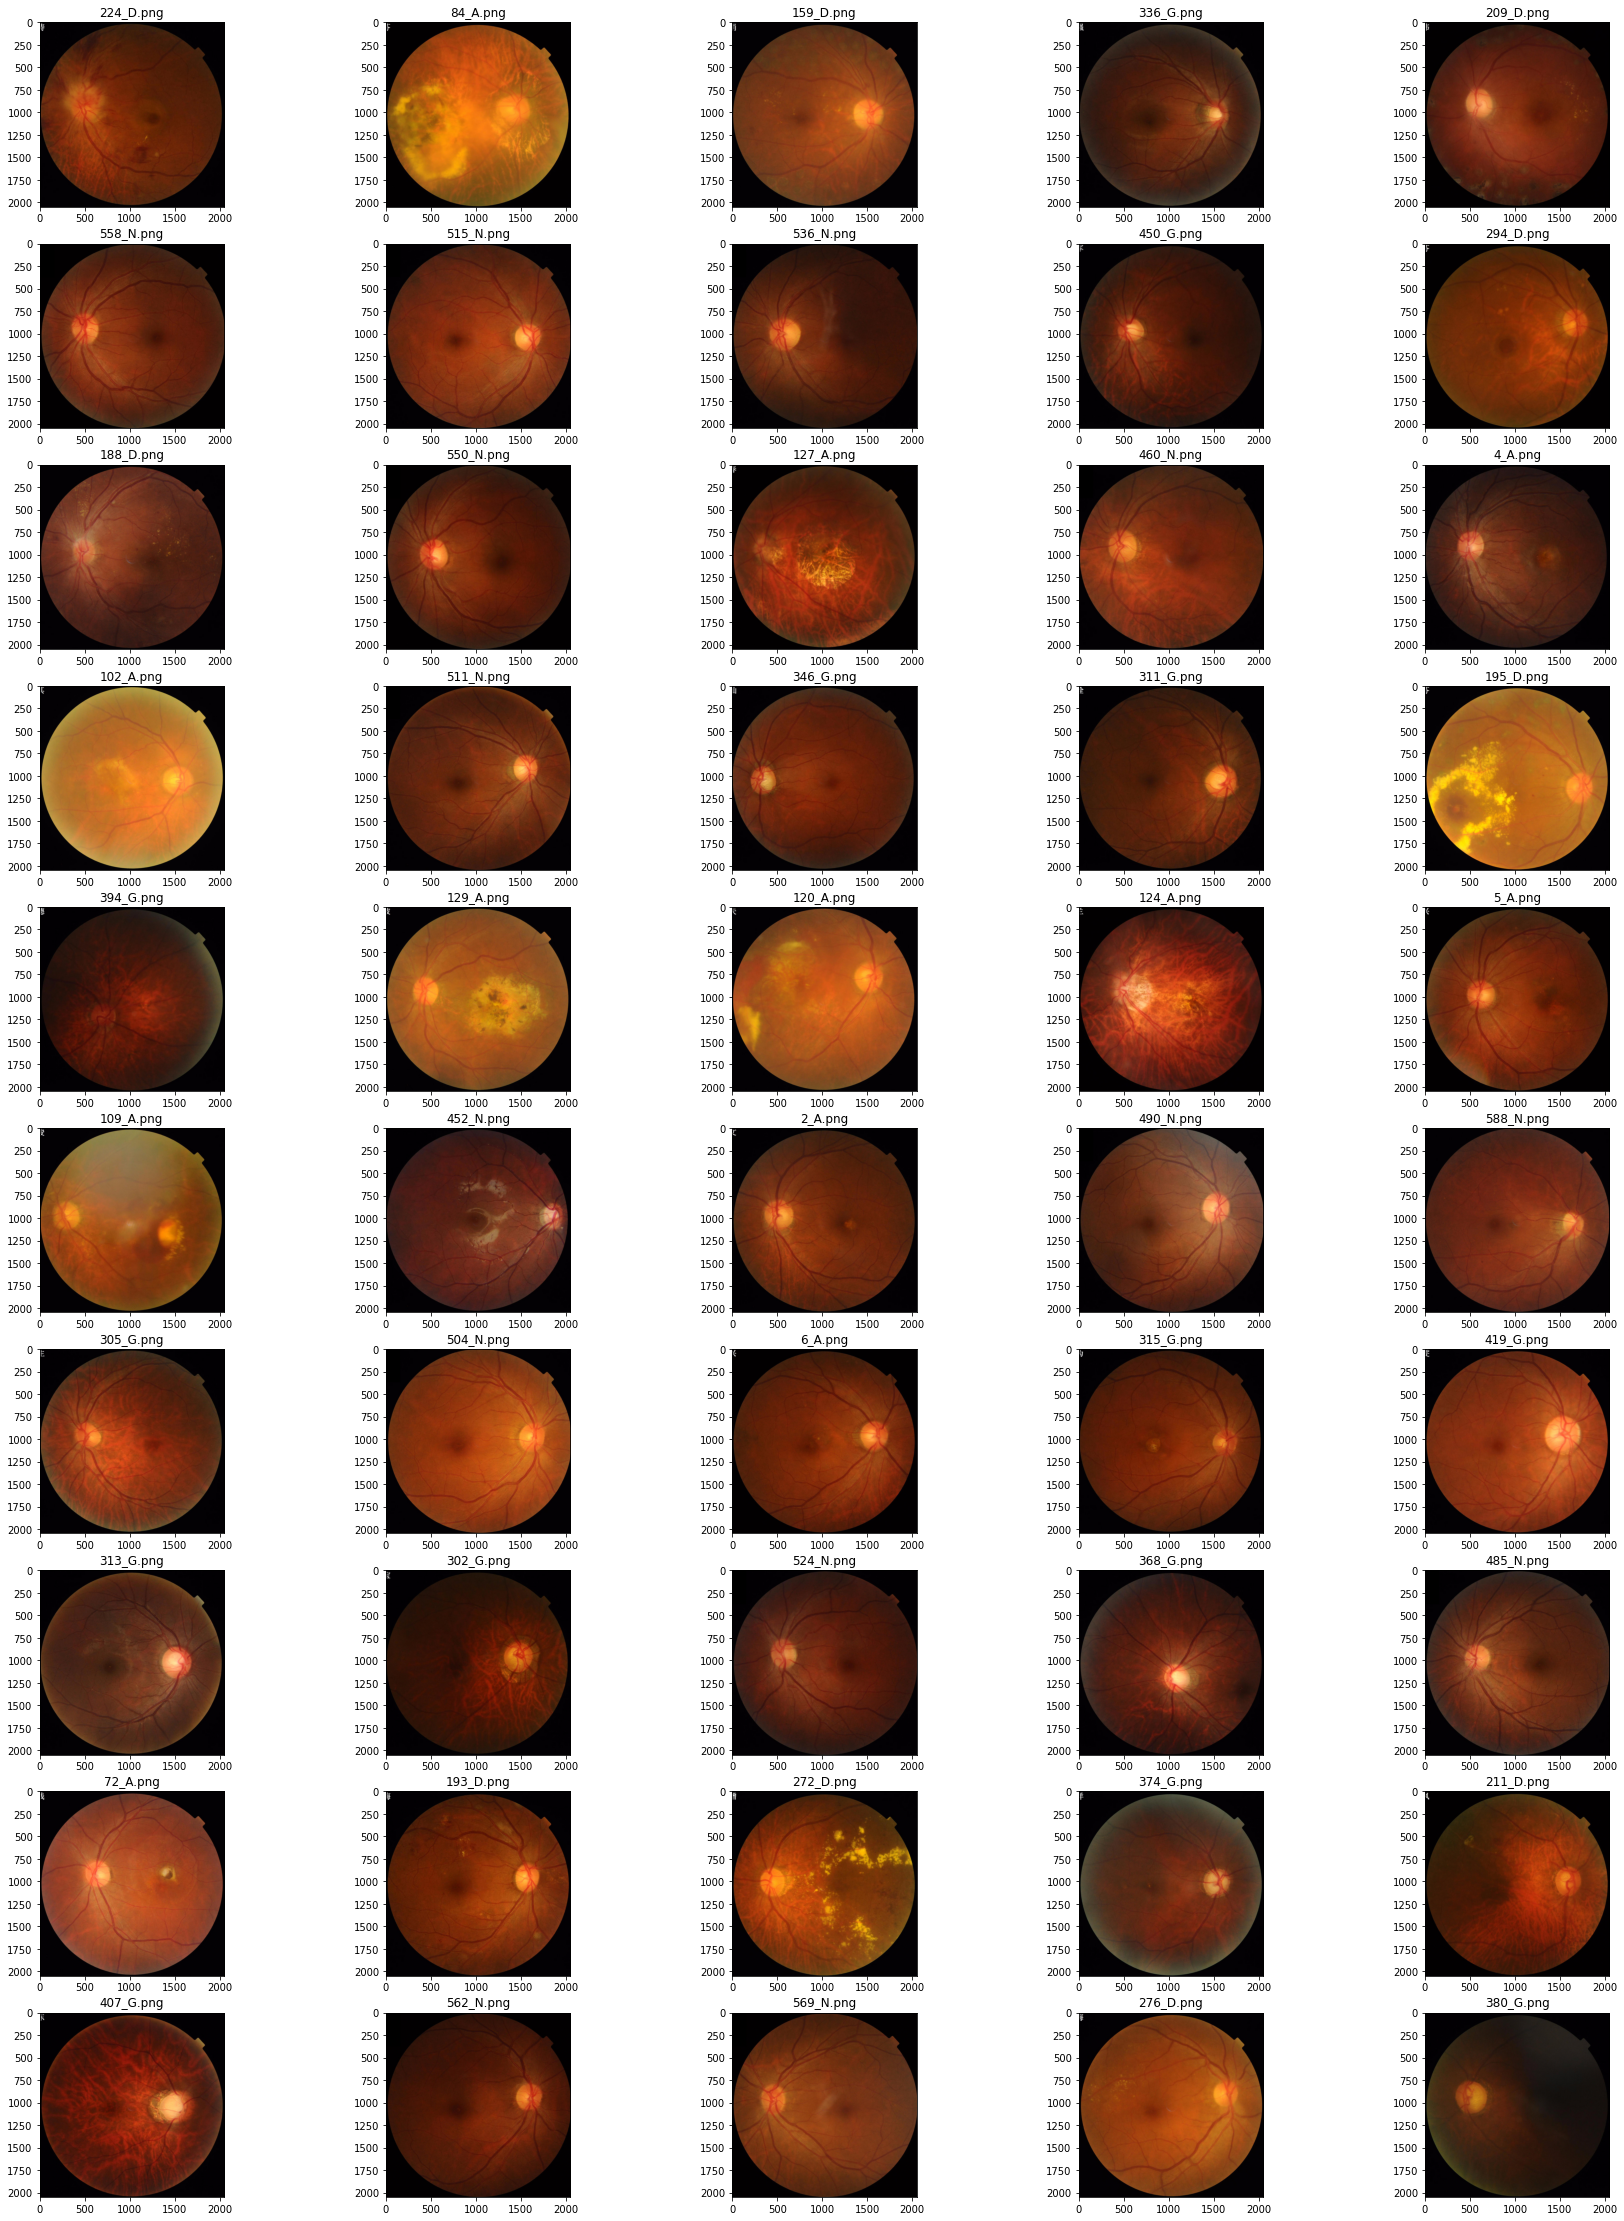

In [5]:
fig = plt.figure(figsize = (30, 40))
for i, filename in enumerate(islice(sub_imglist, 50)):
  full_path = os.path.join(train_ds_img, filename)
  img = Image.open(full_path)
  ax = fig.add_subplot(10,5,i+1)
  ax.set_title(filename)
  ax.imshow(img)
plt.show()

# Get the disease types

In [6]:
num_train_imgs = len(train_img_list)
num_test_imgs = len(test_img_list)
## get the types of images using lambda function for clarity,
## can also be done using list comprehension ##
train_type_list = list(map(lambda x: x.split('.png')[0].split('_')[1], 
                           train_img_list))
test_type_list = list(map(lambda x: x.split('.png')[0].split('_')[1], 
                          test_img_list))
train_types = list(set(train_type_list))
test_types = list(set(test_type_list))
train_types

['N', 'G', 'D', 'A']

Display the samples based disease type and data split

In [8]:
type_count_train = []
for t in train_types:
  type_count_train.append(train_type_list.count(t))
type_count_test = []
for t in train_types:
  type_count_test.append(test_type_list.count(t))
import pandas as pd
df = pd.DataFrame([type_count_train, type_count_test])
df.columns = train_types
type_count_total = df.sum(axis=0)
df = df.append(type_count_total, ignore_index=True)
total_split = df.sum(axis=1)
df['Total'] = total_split.values
df.index = ['train','test', 'Total']
df_rename = df.rename(columns={'D': 'DR', 'G':'Glaucoma', 'A': 'AMD', 'N':'Normal' })
df_rename

,Normal,Glaucoma,DR,AMD,Total
train,150,150,150,150,600
test,50,50,50,50,200
Total,200,200,200,200,800


# Display the samples on the plot

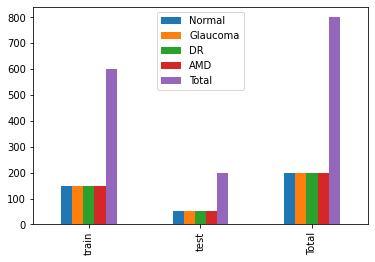

In [10]:
ax = df_rename.plot.bar()

# Visualize the segmentation mask

In [ ]:
import numpy as np

def compute_ratio(img_mask):
  img_mask_b=np.array(img_mask)[:,:,0]
  c_pos=np.sum(img_mask_b==255)
  c_neg=np.sum(img_mask_b==0)
  pos_neg_ratio=c_pos/c_neg
  
  return pos_neg_ratio

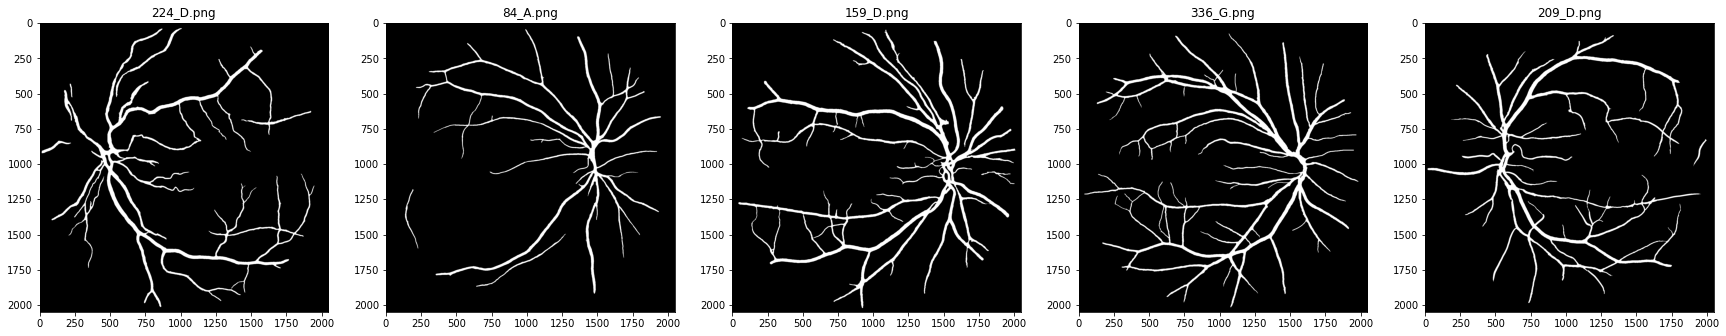

 The average positive and negative sample ratio is 0.07125861070295791


In [17]:
train_mask = os.path.join(train_dir,'Ground truth/')
train_mask_ls = sorted(os.listdir(train_mask))

random.seed(1)  ## random seed for reproduce the same images
sub_masklist = random.sample(train_mask_ls, 5)

fig = plt.figure(figsize = (30, 15))
pos_neg_ratio = 0
for i, filename in enumerate(islice(sub_masklist, 5)):
  full_path = os.path.join(train_mask, filename)
  img_mask = Image.open(full_path)
  pos_neg_ratio += compute_ratio(img_mask)
  ax = fig.add_subplot(1, 5,i+1)
  ax.set_title(filename)
  ax.imshow(img_mask)
plt.show()


print(f' The average positive and negative sample ratio is {pos_neg_ratio/5}')


# Even small sample size (i.e. 5) used to compute the positive and negative pixel retio, it is worth to note that the positive pixels are much less than the negative pixels. It is worth to train the model using focal loass when more time is available to implement 